# Multivariate Forecasting with Autoformer

This notebook outlines the application of AutoFormer, a recently-proposed transformer-based model for time series forecasting, to a Electricity Consumption Dataset. The dataset contains the hourly electricity consumption of 321 customers from 2012 to 2014. 

## Package Imports and Global Variables

In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Append parent directory to sytem path so we can import from sibling directory 
parent_dir = os.path.abspath('..')

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [3]:
from transformer_forecasting.model import AutoFormer
from transformer_forecasting.datasets import CustomDataset
from transformer_forecasting.utils.data import split_data, get_hour_features, scale_data
from transformer_forecasting.utils.tools import EarlyStopping, adjust_learning_rate
from transformer_forecasting.utils.train import train_step, val_step, test

from transformer_forecasting.utils.metrics import metric

In [4]:
# Global Constants
CSV_PATH = "../datasets/electricity/electricity.csv"

VAL_PERC = .1
TEST_PERC = .1

BATCH_SIZE = 32

SEQ_LEN = 96 #Input Sequence Length
START_TOKEN_LEN = 48 #Start Token Length
PRED_LEN = 96 #Prediction sequence length
FEATURES = "M"

EPOCHS = 10
LR = .0001
LRADJ = "type1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 ## Data Loading

### Load Raw Canadian Weather Dataset File

In [5]:
# Read Data
df = pd.read_csv(CSV_PATH)
df

,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,OT
0,2016-07-01 02:00:00,14.000,69.000,234.000,415.000,215.000,1056.000,29.000,840.000,226.000,...,676.000,372.000,80100.000,4719.000,5002.000,48.000,38.000,1558.000,182.000,2162.000
1,2016-07-01 03:00:00,18.000,92.000,312.000,556.000,292.000,1363.000,29.000,1102.000,271.000,...,805.000,452.000,95200.000,4643.000,6617.000,65.000,47.000,2177.000,253.000,2835.000
2,2016-07-01 04:00:00,21.000,96.000,312.000,560.000,272.000,1240.000,29.000,1025.000,270.000,...,817.000,430.000,96600.000,4285.000,6571.000,64.000,43.000,2193.000,218.000,2764.000
3,2016-07-01 05:00:00,20.000,92.000,312.000,443.000,213.000,845.000,24.000,833.000,179.000,...,801.000,291.000,94500.000,4222.000,6365.000,65.000,39.000,1315.000,195.000,2735.000
4,2016-07-01 06:00:00,22.000,91.000,312.000,346.000,190.000,647.000,16.000,733.000,186.000,...,807.000,279.000,91300.000,4116.000,6298.000,75.000,40.000,1378.000,191.000,2721.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2019-07-01 21:00:00,11.000,116.000,8.000,844.000,384.000,1590.000,51.000,1412.000,407.000,...,1897.000,1589.000,166500.000,9917.000,10412.000,324.000,21.000,1870.000,162.000,2773.000
26300,2019-07-01 22:00:00,11.000,103.000,8.000,749.000,371.000,1366.000,47.000,1265.000,369.000,...,1374.000,1336.000,158800.000,6812.000,8956.000,302.000,20.000,1506.000,438.000,2755.000
26301,2019-07-01 23:00:00,12.000,93.000,8.000,650.000,346.000,1282.000,48.000,1079.000,308.000,...,938.000,1311.000,154300.000,6602.000,5910.000,302.000,18.000,1864.000,621.000,2650.000
26302,2019-07-02 00:00:00,10.000,92.000,8.000,646.000,349.000,1261.000,48.000,1009.000,288.000,...,833.000,1227.000,141900.000,6546.000,5502.000,259.000,33.000,2623.000,783.000,2719.000


### Data Preprocessing

The raw data has to be processed prior to initializing the dataset. This includes first filling missing entries with the column mean. Second, the data is split sequentially into train, validation and test based on `VAL_SIZE` and `TEST_SIZE` global variables. Once the datasets have been split, the columns are standardized by subtracting the mean and scaling to unti variance.

Additionally, time-based features are calculated using the date index of each dataset. These time based features are used as the basis to the temporal embeddings that are added to the value embeddings prior to being fed through the Autoformer.  

In [6]:
# FIll nan with last valid observation 
df.fillna(df.mean(), inplace=True)

/tmp/ipykernel_5292/3227414236.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


In [7]:
# Carve out date index and features
dates = pd.to_datetime(df.iloc[:, 0])
data = df.iloc[:, 1:].values

print(dates.shape, data.shape)
col_name_list = df.columns[1:]

(26304,) (26304, 321)


In [8]:
# Split data into train, test and validation
n_samples = data.shape[0]
n_val = int(n_samples * VAL_PERC)
n_test = int(n_samples * TEST_PERC)
(train_data, train_dates), (val_data, val_dates), (test_data, test_dates) = split_data(data, dates, n_val, n_test)

# Get Time Based Features for each dataset
train_time_feat = get_hour_features(train_dates)
val_time_feat = get_hour_features(val_dates)
test_time_feat = get_hour_features(test_dates)

# Standardize features for each dataset 
train_data = scale_data(train_data) 
val_data = scale_data(val_data)
test_data = scale_data(test_data)

print(train_data.shape, val_data.shape, test_data.shape)
print(train_time_feat.shape, val_time_feat.shape, test_data.shape)


(21044, 321) (2630, 321) (2630, 321)
(21044, 4) (2630, 4) (2630, 321)


In [9]:
# Initialize train dataset and train dataloader
train_dataset = CustomDataset(data=train_data,
                                   time_feat=train_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

# Initialize val dataset and val dataloader
val_dataset = CustomDataset(data=val_data,
                                   time_feat=val_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)

# Initialize test dataset and test dataloader
test_dataset = CustomDataset(data=test_data,
                                   time_feat=test_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)


## Model

###  Autoformer Overview

Autoformer is a tranformer architecture for LSTF that aims to surmount the quadratic complexity of the attention mechanism and enhance prediction accuracy. In doing so, the Autoformer proposes two novel components, the Series Deocmposition Block and the Autocorrelation Block, that function as follows:

- **Series Decomposition Block:** Block that decomposes series into seasonal and trend-cyclical components. Used throughout the architecture to allow for the progressive decomposition of complex time series. 
- **Autocorrelation Block:** Self attention mechanism that conducts dependecy discovery and representation aggregation at the subseries level. Assuming that sub-series at the same phase position exhibit similar temporal processes, the Autocorrelation block construct series level connections based on the process similarity which is derived using series periodicity. 

At the top level, autoformer consists of an encoder and a decoder, each of which is composed sets of Auto-Correlation, Series Decomposition and Feed Forward Blocks with residual connections. 

<p align="center">
<img width="800" alt="Screen Shot 2021-09-28 at 5 41 20 PM" src="https://user-images.githubusercontent.com/34798787/149202576-720856f7-c827-4e3d-85d7-0053328e1c8d.png">  
</p>


### Initialize Model
With a high level understanding of the architecture in place, the following sections will outline the application of Autoformer to the Canadian Weather Dataset. The first step is to initialize the Autoformer model with the appropriate models.

In [10]:
# Initialize model with input and output dimension and optional parameter factor 
af_model = AutoFormer(
    seq_len=SEQ_LEN, 
    label_len=START_TOKEN_LEN,
    pred_len=PRED_LEN,
    enc_in=321, 
    dec_in=321,
    c_out=321, 
    factor=3,
    freq="h"
)

# Send model to GPU
af_model.to(DEVICE)

# Initialize optimizer to train model
model_optim = optim.Adam(af_model.parameters(), lr=LR)

# Define Loss 
criterion = torch.nn.MSELoss()

## Train and Validate
Now that we have initialized the model and the dataset, we can proceed to train and validate the model. For each epoch, the validation loss is recorded and training is early stopped if the validation loss increases on consecutive epochs.

In [11]:
#Train Step
run_name = f"run_{str(datetime.now().strftime('%s'))}"

# Define path to save model checkoints
path = os.path.join("./checkpoints/", run_name)
if not os.path.exists(path):
    os.makedirs(path)

# Define early stopping criteria
early_stopping = EarlyStopping(patience=2, verbose=True)

train_loss_list = []
val_loss_list = []
for epoch in range(EPOCHS):
    train_loss = train_step(af_model, train_loader, model_optim, criterion, DEVICE, PRED_LEN, START_TOKEN_LEN)
    val_loss = val_step(af_model, val_loader, criterion, DEVICE, PRED_LEN, START_TOKEN_LEN)

    early_stopping(val_loss, af_model, path)
    if early_stopping.early_stop:
        print("Early Stopping")
        break
    
    adjust_learning_rate(model_optim, epoch+1, adjust_type="type1", lr=LR)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

Validation loss decreased (inf --> 0.313644).  Saving model ...
Updating learning rate to 0.0001
Validation loss decreased (0.313644 --> 0.306738).  Saving model ...
Updating learning rate to 5e-05
Validation loss decreased (0.306738 --> 0.292830).  Saving model ...
Updating learning rate to 2.5e-05
Validation loss decreased (0.292830 --> 0.283628).  Saving model ...
Updating learning rate to 1.25e-05
Validation loss decreased (0.283628 --> 0.279027).  Saving model ...
Updating learning rate to 6.25e-06
Validation loss decreased (0.279027 --> 0.273237).  Saving model ...
Updating learning rate to 3.125e-06
Validation loss decreased (0.273237 --> 0.268979).  Saving model ...
Updating learning rate to 1.5625e-06
Validation loss decreased (0.268979 --> 0.263191).  Saving model ...
Updating learning rate to 7.8125e-07
Validation loss decreased (0.263191 --> 0.260234).  Saving model ...
Updating learning rate to 3.90625e-07
Validation loss decreased (0.260234 --> 0.259993).  Saving model ..

### Visualize Train and Validation Performance
The Mean Squared Error of the models performance accross epochs on both the train and validation set are plotted/

Text(0, 0.5, 'Mean Squared Error')

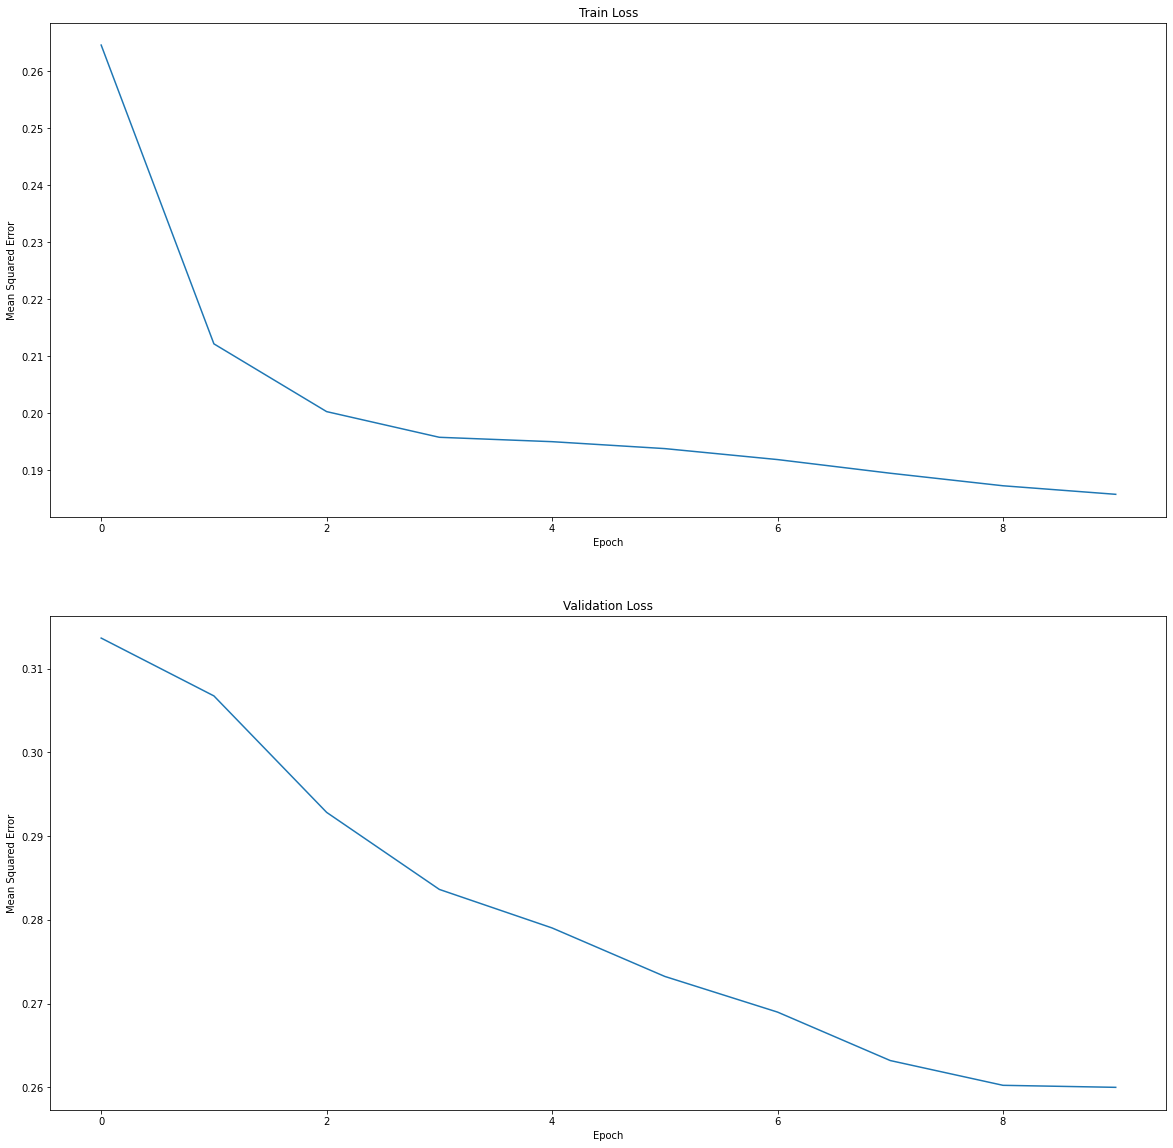

In [12]:
# Initialize Plot
f, axarr = plt.subplots(2, 1, figsize=(20, 20)) 

# Get X Index list
x_index = [i for i in range(len(train_loss_list))]

# Plot and Label 
axarr[0].plot(x_index, train_loss_list)
axarr[0].set_title("Train Loss")
axarr[0].set_xlabel("Epoch")
axarr[0].set_ylabel("Mean Squared Error")
axarr[1].plot(x_index, val_loss_list)
axarr[1].set_title("Validation Loss")
axarr[1].set_xlabel("Epoch")
axarr[1].set_ylabel("Mean Squared Error")

## Test

With the trained model from the previous step, we can apply it to the test set to get an unbias estimate of the models performance. Additionally, we can visualize the results to build some intuition about the forecasts being generated. 

In [13]:
input, pred, true = test(af_model, test_loader, run_name, DEVICE, PRED_LEN, START_TOKEN_LEN)

### Visualize Predictions

To build an intuition about the forecasting produced by the model, we sample a set of 10 variables and plot a single prediction for each. This includes plotting the input, output and ground truth and a single figure. 


In [14]:
ss_indices = np.random.choice(range(pred.shape[0]), 1, replace=False)
ss_pred = pred[ss_indices]
ss_true = true[ss_indices]
ss_input = input[ss_indices]

col_indices = list(np.random.choice(range(ss_pred.shape[2]), 10, replace=False))
print(len(col_indices), ss_pred.shape, ss_true.shape, ss_input.shape)

10 (1, 96, 321) (1, 96, 321) (1, 96, 321)


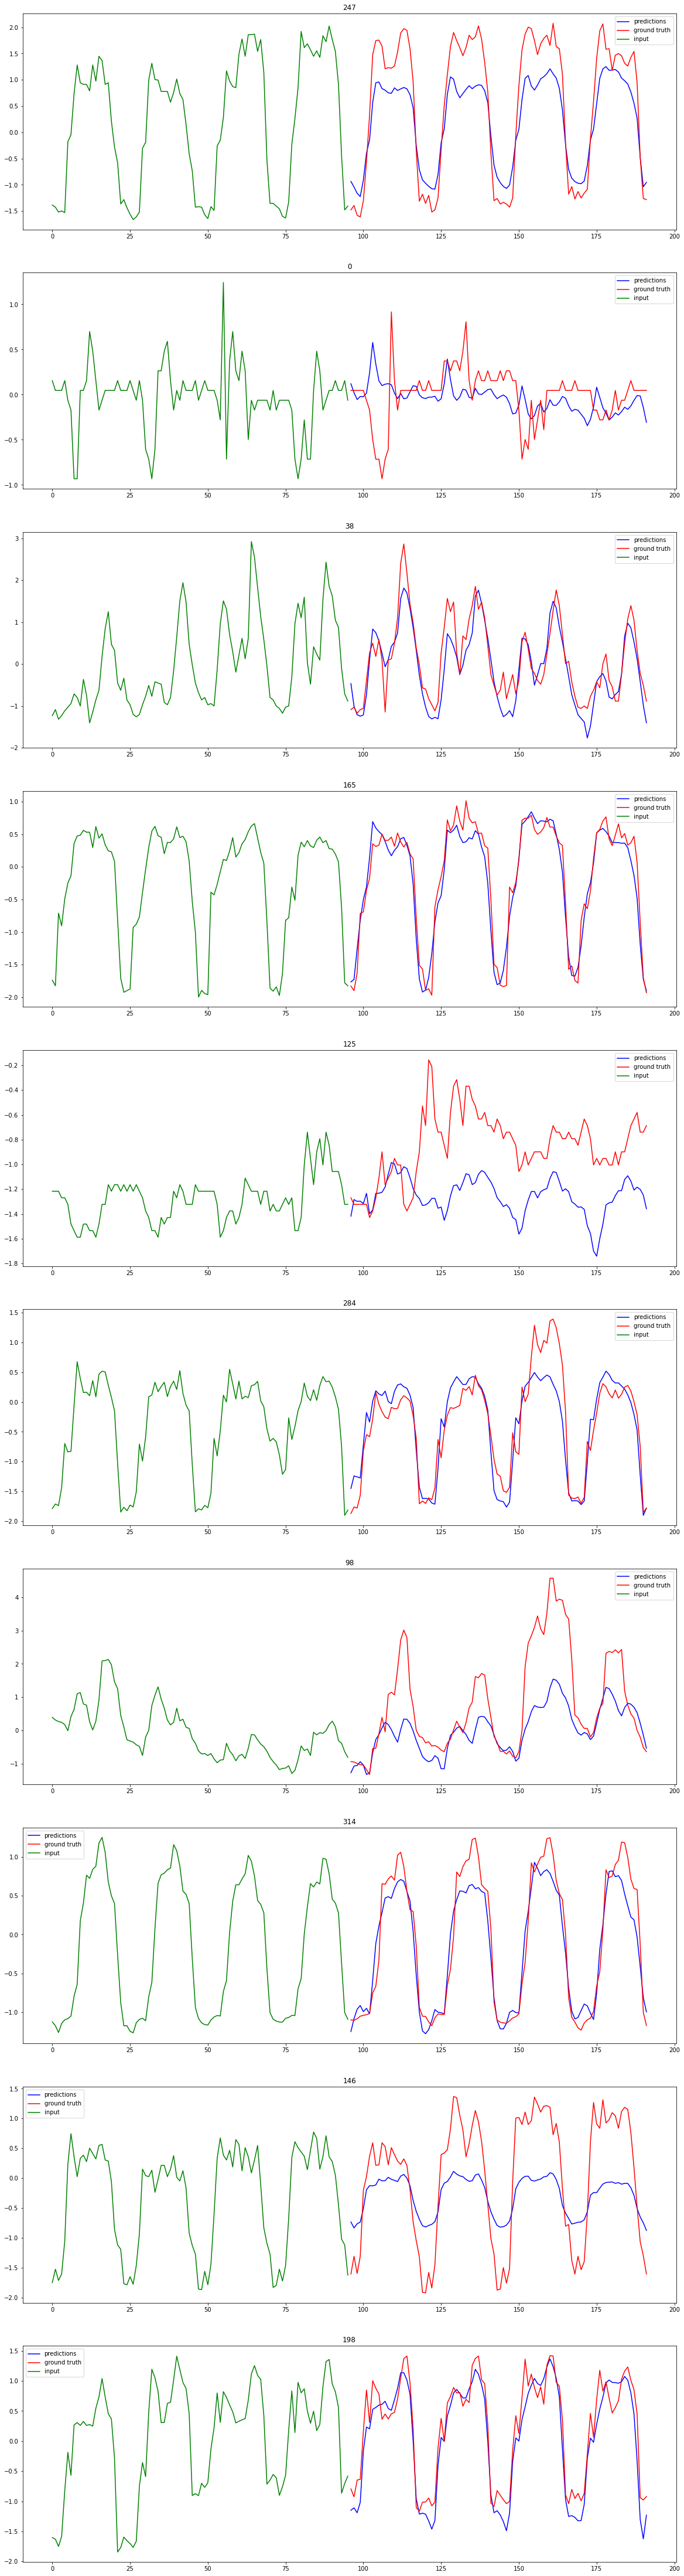

In [15]:
f, axarr = plt.subplots(len(col_indices), ss_pred.shape[0], figsize=(20, 80))
for fig_x, i in enumerate(col_indices):
    series_preds = ss_pred[:, :, i].squeeze()
    series_trues = ss_true[:, :, i].squeeze()
    series_inputs = ss_input[:, :, i].squeeze()
    
    input_len = series_inputs.shape[0]
    pred_gt_len = series_preds.shape[0]
    input_x = np.array([i for i in range(input_len)])
    x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
    axarr[fig_x].plot(x, series_preds, c="blue", label="predictions")
    axarr[fig_x].plot(x, series_trues, c="red", label="ground truth")
    axarr[fig_x].plot(input_x, series_inputs, c="green", label="input")
    axarr[fig_x].legend()
    axarr[fig_x].set_title(col_name_list[i])

### Quantitative Results
To assess the performance of AutoFormer on the Canadian Weather dataset, we calculate its performance on the test set using a set of metrics that are commonly used in time series forecasting. The metrics include Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percental Error (MAPE) and Mean Squared Percentage Error (MSPE). 

In [17]:
mae, mse, rmse, mape, mspe = metric(pred, true)
print(f"MAE: {mae} MSE: {mse} RMSE: {rmse}")

MAE: 0.3208725154399872 MSE: 0.22209176421165466 RMSE: 0.47126612067222595
